# Formula 1 - Modelling

### Import Relevant Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import requests
import bs4
from bs4 import BeautifulSoup
import time
from tqdm import tqdm
import math

In [3]:
from collections import defaultdict
import regex as re
import datetime

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Perceptron, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import r2_score
import joblib

In [5]:
import xgboost
from xgboost import XGBRegressor

# Load The Data

In [6]:
driver_standings = pd.read_csv('./CSV/driver_standings.csv').drop(['Unnamed: 0'], axis=1)

In [7]:
constructor_standings = pd.read_csv('./CSV/constructor_standings.csv').drop(['Unnamed: 0'], axis=1)

In [8]:
main_df = pd.read_csv('./CSV/main_df.csv').drop(['Unnamed: 0'], axis=1)

In [9]:
main_df.head()

,season,round,race_name,name,constructor,grid,qual_position,q_best,q_worst,q_mean,...,circuitId,locality,country,type,direction,length,weather,finish_position,points,filled_splits
0,2014,1,australian,Nico Rosberg,mercedes,3.0,3.0,92.564,104.595,99.807667,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",1.0,25.0,0.000
1,2014,1,australian,Kevin Magnussen,mclaren,4.0,4.0,90.949,105.745,99.980333,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",2.0,18.0,26.777
2,2014,1,australian,Jenson Button,mclaren,10.0,11.0,91.396,104.437,97.916500,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",3.0,15.0,30.027
3,2014,1,australian,Fernando Alonso,ferrari,5.0,5.0,91.388,105.819,100.004000,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",4.0,12.0,35.284
4,2014,1,australian,Valtteri Bottas,williams,15.0,10.0,91.601,108.147,101.200000,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",5.0,10.0,47.639


,season,round,race_name,name,constructor,grid,qual_position,q_best,q_worst,q_mean,...,circuitId,locality,country,type,direction,length,weather,finish_position,points,filled_splits
0,2014,1,australian,Nico Rosberg,mercedes,3.0,3.0,92.564,104.595,99.807667,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",1.0,25.0,0.000
1,2014,1,australian,Kevin Magnussen,mclaren,4.0,4.0,90.949,105.745,99.980333,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",2.0,18.0,26.777
2,2014,1,australian,Jenson Button,mclaren,10.0,11.0,91.396,104.437,97.916500,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",3.0,15.0,30.027
3,2014,1,australian,Fernando Alonso,ferrari,5.0,5.0,91.388,105.819,100.004000,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",4.0,12.0,35.284
4,2014,1,australian,Valtteri Bottas,williams,15.0,10.0,91.601,108.147,101.200000,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",5.0,10.0,47.639


,season,round,race_name,name,constructor,grid,qual_position,q_best,q_worst,q_mean,...,circuitId,locality,country,type,direction,length,weather,finish_position,points,filled_splits
0,2014,1,australian,Nico Rosberg,mercedes,3.0,3.0,92.564,104.595,99.807667,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",1.0,25.0,0.000
1,2014,1,australian,Kevin Magnussen,mclaren,4.0,4.0,90.949,105.745,99.980333,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",2.0,18.0,26.777
2,2014,1,australian,Jenson Button,mclaren,10.0,11.0,91.396,104.437,97.916500,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",3.0,15.0,30.027
3,2014,1,australian,Fernando Alonso,ferrari,5.0,5.0,91.388,105.819,100.004000,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",4.0,12.0,35.284
4,2014,1,australian,Valtteri Bottas,williams,15.0,10.0,91.601,108.147,101.200000,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",5.0,10.0,47.639


In [10]:
# age variable committed to csv as datetime type, loaded as a string. Reformat to remove ' days' from instances.

def day_split(age):
    return int(age.split(' ')[0])

main_df.ageDuringRace = main_df.ageDuringRace.apply(day_split)

In [11]:
main_df.dtypes

season               int64
round                int64
race_name           object
name                object
constructor         object
grid               float64
qual_position      float64
q_best             float64
q_worst            float64
q_mean             float64
ageDuringRace        int64
circuitId           object
locality            object
country             object
type                object
direction           object
length             float64
weather             object
finish_position    float64
points             float64
filled_splits      float64
dtype: object

season               int64
round                int64
race_name           object
name                object
constructor         object
grid               float64
qual_position      float64
q_best             float64
q_worst            float64
q_mean             float64
ageDuringRace        int64
circuitId           object
locality            object
country             object
type                object
direction           object
length             float64
weather             object
finish_position    float64
points             float64
filled_splits      float64
dtype: object

season               int64
round                int64
race_name           object
name                object
constructor         object
grid               float64
qual_position      float64
q_best             float64
q_worst            float64
q_mean             float64
ageDuringRace        int64
circuitId           object
locality            object
country             object
type                object
direction           object
length             float64
weather             object
finish_position    float64
points             float64
filled_splits      float64
dtype: object

In [12]:
race_dps = []

for years in np.array(main_df.season.unique()):
    race_dps.extend([(years, race_name) if race_name != '70th-anniversary' 
                     else (race_name.split('-')[0], race_name.split('-')[1], years)
                     for race_name in 
                     list(main_df[main_df.season == years]['race_name'].unique())])
    race_dps.extend([(years, 'usa') for race_name in
                 list(main_df[main_df.season == years]['race_name'].unique()) if race_name=='us'])
    race_dps.extend([(years, 'mexico') for race_name in
                 list(main_df[main_df.season == years]['race_name'].unique()) if race_name=='mexican'])

# Model Tuning

### Train-Test Split on pre-2020 to predict 2020 onwards

In [13]:
main = main_df.copy()

train = main[main.season<2020]
test = main[main.season==2020]

r_train = train.pop('finish_position')
y_train = train.pop('filled_splits')
p_train = train.pop('points')
X_train = train
r_test = test.pop('finish_position')
y_test = test.pop('filled_splits')
X_test = test
p_test = test.pop('points')

In [14]:
# Natural Language Processing
cvec_weather = CountVectorizer(stop_words='english', binary=True)#strip_words

# Dummification
ohe_direction = OneHotEncoder(handle_unknown='ignore')
ohe_country = OneHotEncoder(handle_unknown='ignore')
ohe_locality = OneHotEncoder(handle_unknown='ignore')
ohe_type = OneHotEncoder(handle_unknown='ignore')
ohe_season = OneHotEncoder(handle_unknown='ignore')
ohe_round = OneHotEncoder(handle_unknown='ignore')
ohe_qual_pos = OneHotEncoder(handle_unknown='ignore')
ohe_grid_pos = OneHotEncoder(handle_unknown='ignore')
ohe_racename = OneHotEncoder(handle_unknown='ignore')

# Standardisation
scaler_q_mean = StandardScaler(with_mean=False)
scaler_q_best = StandardScaler(with_mean=False)
scaler_q_worst = StandardScaler(with_mean=False)
scaler_length = StandardScaler(with_mean=False)
scaler_age = StandardScaler(with_mean=False)

In [15]:
col_trans = ColumnTransformer([
                               ('weather', cvec_weather, 'weather'),
                               ('direction', ohe_direction, ['direction']),
                               ('country', ohe_country, ['country']),
                               ('locality', ohe_locality, ['locality']),
                               ('type', ohe_type, ['type']),
                               ('season', ohe_season, ['season']),
                               ('round', ohe_round, ['round']),
                               ('qual_position', ohe_qual_pos, ['qual_position']),
                               ('grid', ohe_grid_pos, ['grid']),
                               ('race_name', ohe_racename, ['race_name']),
                               ('q_mean', scaler_q_mean, ['q_mean']),
                               ('q_best', scaler_q_best, ['q_best']),
                               ('q_worst', scaler_q_worst, ['q_worst']),
                               ('length', scaler_length, ['length']),
                               ('ageDuringRace', scaler_age, ['ageDuringRace'])
                              ], 
                             )

In [16]:
# weat = main_df.weather
# c = CountVectorizer(stop_words='english', binary=True).fit(weat)
# pd.DataFrame(c.transform(weat).toarray(), columns=c.vocabulary_)

In [17]:
# # a selection of some of the different models run to be called on for testing.

# lin = LinearRegression(fit_intercept=False)
# rfr = RandomForestRegressor(n_estimators=1000, n_jobs=-2, verbose=1, criterion='mse', ccp_alpha=0.04)
# # rcv = RidgeCV(alphas=[0.1, 0.01, 0.05, 0.001], fit_intercept=True, cv=4)
# # rid = Ridge(alpha=0.1, solver='auto', max_iter=1000)
# las = Lasso(alpha=3.2, max_iter=3000, tol=5220460544.0)
# # lcv = LassoCV(alphas=[0.1, 0.01, 0.05, 0.001], fit_intercept=True, cv=4)
# # eln = ElasticNet()
# # ecv = ElasticNetCV(l1_ratio=0.001, n_alphas=150, n_jobs=-2, alphas=[0.1, 0.05, 0.01])
# bgr = BaggingRegressor(base_estimator=lin, n_estimators=10000, n_jobs=-2, verbose=2)
# gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.001, init=las, max_depth=30, verbose=1)

In [18]:
# params = {'gamma': [None, 0.1, 0.5, 0.75, 1, 1.5],
#           'learning_rate': [None, 0.01, 0.05, 0.1, 0,15, 0.2],
#           'max_depth': [None, 2, 3, 4, 5, 6],
#           'n_estimators': [100, 150, 200, 250],
#           'n_jobs': [-2],
#           'reg_alpha': [0, None],
#           'reg_lambda': [1, None],
#           'subsample': [1, None, 0.8, 0.5, 0.6]
#           }

In [19]:
params = {'gamma': [None, 0.1, 0.5, 0.75, 1, 1.5],
          'learning_rate': [None, 0.01, 0.05, 0.1, 0,15, 0.2],
          'max_depth': [None, 2, 3, 4, 5, 6],
          'n_estimators': [100, 150],
          'n_jobs': [-2],
          'reg_alpha': [0, None],
          'reg_lambda': [1, None],
          'subsample': [1, None, 0.8, 0.5, 0.6]
          }

In [20]:
def points(pos):
    if pos==1: return 25
    if pos==2: return 18
    if pos==3: return 15
    if pos==4: return 12
    if pos==5: return 10
    if pos==6: return 8
    if pos==7: return 6
    if pos==8: return 4
    if pos==9: return 2
    if pos==10: return 1
    return 0

def constructor(name):
    return main_df[main_df.name==name][constructor]

def driver_id(name):
    name = name.split()[1].strip(' ').lower()
    if name == 'fittipaldi':
        return 'pietro_fittipaldi'
    elif name == 'räikkönen':
        return 'raikkonen'
    elif name == 'pérez':
        return 'perez'
    elif name == 'hülkenberg':
        return 'hulkenberg'
    elif name == 'magnussen':
        return 'kevin_magnussen'
    elif name == 'verstappen':
        return 'max_verstappen'
    else:
        return name


best = {'gamma': None,
        'learning_rate': None,
        'max_depth': None,
        'n_estimators': None,
        'reg_alpha': None,
        'reg_lambda': None,
        'subsample': None}


drivers = {'spearman': None,
           'pearson': None,
           'r2': None,
           'mse': None,
           'rmse': None}


constructors = {'spearman': None,
                'pearson': None,
                'r2': None,
                'mse': None,
                'rmse': None}

In [21]:
size = len(params['gamma'])*len(params['learning_rate'])*len(params['max_depth'])*len(params['n_estimators'])*len(params['n_jobs'])*len(params['reg_alpha'])*len(params['reg_lambda'])*len(params['subsample'])

progress = 0

In [22]:
print(size)

10080
10080
10080


In [23]:
for gamma in params['gamma']:
    for learning_rate in params['learning_rate']:
        for max_depth in params['max_depth']:
            for n_estimators in params['n_estimators']:
                for reg_alpha in params['reg_alpha']:
                    for reg_lambda in params['reg_lambda']:
                        for subsample in params['subsample']:
                            progress += 1
                            print(f'{progress}/{size}')
                            try:
                                xgb = XGBRegressor(gamma=gamma, learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, reg_alpha=reg_alpha, reg_lambda=reg_lambda, subsample=subsample, n_jobs=-2, verbosity=1)
                                pipe = make_pipeline(col_trans, xgb)
                                pipe.fit(X_train, y_train)
                                view_test = X_test.copy()

                                view_test['pred'] = pipe.predict(X_test)
                                view_test['true'] = y_test
                                view_test['true_finish_positions'] = r_test

                                test_indices = view_test.index

                                view_train = X_train.copy()
                                view_train['true'] = y_train
                                view_train['pred'] = pipe.predict(X_train)
                                view_train['true_finish_positions'] = r_train

                                train_indices = view_train.index

                                overall = pd.concat([view_test, view_train])
                                overall.sort_values(['season', 'round', 'pred'], inplace=True)

                                true_positions_test = []
                                indices_test = []
                                for race in race_dps:
                                    if race[1]=='anniversary':
                                        year = 2020
                                        circuit = '70th-anniversary'
                                    else:
                                        year = race[0]
                                        circuit = race[1]

                                    year_race = overall[(overall.season==year)&(overall.race_name==circuit)]

                                    def indexer(ind):
                                        return sorted(year_race.pred).index(ind)+1

                                    true_positions_test.extend(year_race.pred.apply(indexer))
                                    indices_test.extend(year_race.pred.apply(indexer).index)
                                positional_convert_test = pd.DataFrame(true_positions_test, index=indices_test).sort_index()
                                view_test['pred_positions'] = positional_convert_test

                                true_positions_train = []
                                indices_train = []
                                for race in race_dps:
                                    if race[1]=='anniversary':
                                        year = 2020
                                        circuit = '70th-anniversary'
                                    else:
                                        year = race[0]
                                        circuit = race[1]
                                    year_race = overall[(overall.season==year)&(overall.race_name==circuit)]

                                    def indexer(ind):
                                        return sorted(year_race.pred).index(ind)+1

                                    true_positions_train.extend(year_race.pred.apply(indexer))
                                    indices_train.extend(year_race.pred.apply(indexer).index)
                                positional_convert_train = pd.DataFrame(true_positions_train, index=indices_train).sort_index()
                                view_train['pred_positions'] = positional_convert_train


                                view_test['points'] = view_test.pred_positions.apply(points)

                                driver_points = view_test[['name', 'points']]
                                predicted_standings_driver = driver_points.groupby('name').agg('sum').sort_values(by='points', ascending=False)
                                predicted_standings_driver.reset_index(inplace=True)

                                predicted_standings_driver['driverId'] = predicted_standings_driver.name.apply(driver_id)
                                predicted_standings_driver.drop(['name'], axis=1, inplace=True)
                                predicted_standings_driver = predicted_standings_driver.reindex(columns=['driverId', 'points'])

                                driver_comparison = driver_standings.drop(['position'], axis=1)

                                driver_correlation_comparison = predicted_standings_driver.merge(driver_comparison, how='inner', on='driverId')
                                driver_correlation_comparison.columns=['driver', 'pred_points', 'true_points']

                                def pred_indexer(ind, df=driver_correlation_comparison):
                                    return sorted(df.pred_points, reverse=True).index(ind)+1
                                def true_indexer(ind, df=driver_correlation_comparison):
                                    return sorted(df.true_points, reverse=True).index(ind)+1

                                driver_correlation_comparison['pred_positions'] = driver_correlation_comparison.pred_points.apply(pred_indexer)
                                driver_correlation_comparison['true_positions'] = driver_correlation_comparison.true_points.apply(true_indexer)
                                driver_correlation_comparison['Pos Error (Diff: Pred - True)'] = driver_correlation_comparison.pred_positions - driver_correlation_comparison.true_positions

                                spearman_d = round(driver_correlation_comparison[['pred_points', 'true_points']].corr(method='spearman').iloc[0][1], 4)
                                pearson_d = round(driver_correlation_comparison[['pred_points', 'true_points']].corr(method='pearson').iloc[0][1], 4)
                                r2_d = round(r2_score(driver_correlation_comparison['true_points'], driver_correlation_comparison['pred_points']), 4)
                                mse_d = round(metrics.mean_squared_error(driver_correlation_comparison['true_points'], driver_correlation_comparison['pred_points']), 2)
                                rmse_d = round(np.sqrt(metrics.mean_squared_error(driver_correlation_comparison['true_points'], driver_correlation_comparison['pred_points'])), 3)
                                
                                constructor_points = view_test[['constructor', 'points']]
                                predicted_standings = constructor_points.groupby('constructor').agg('sum').sort_values(by='points', ascending=False)
                                predicted_standings.reset_index(inplace=True)
                                constructor_comparison = constructor_standings.drop(['position'], axis=1)
                                correlation_comparison = predicted_standings.merge(constructor_comparison, how='inner', on='constructor')
                                correlation_comparison.columns=['constructor', 'pred_points', 'true_points']
                                correlation_comparison['pred_positions'] = correlation_comparison.pred_points.apply(pred_indexer, df=correlation_comparison)
                                correlation_comparison['true_positions'] = correlation_comparison.true_points.apply(true_indexer, df=correlation_comparison)

                                spearman = round(correlation_comparison[['pred_points', 'true_points']].corr(method='spearman').iloc[0][1], 4)
                                pearson = round(correlation_comparison[['pred_points', 'true_points']].corr(method='pearson').iloc[0][1], 4)
                                r2 = round(r2_score(correlation_comparison['true_points'], correlation_comparison['pred_points']), 4)
                                mse = metrics.mean_squared_error(correlation_comparison['true_points'], correlation_comparison['pred_points'])
                                rmse = round(np.sqrt(metrics.mean_squared_error(correlation_comparison['true_points'], correlation_comparison['pred_points'])), 3)

                                if (drivers['pearson'] < pearson_d) and (drivers['r2'] < r2_d) and (contructors['pearson'] < pearson) and (constructors['r2'] < r2):

                                    best = {'gamma': gamma,
                                            'learning_rate': learning_rate,
                                            'max_depth': max_depth,
                                            'n_estimators': n_estimators,
                                            'reg_alpha': reg_alpha,
                                            'reg_lambda': reg_lambda,
                                            'subsample': subsample}

                                    drivers = {'spearman': spearman_d,
                                               'pearson': pearson_d,
                                               'r2': r2_d,
                                               'mse': mse_d,
                                               'rmse': rmse_d}

                                    constructors = {'spearman': spearman,
                                                    'pearson': pearson,
                                                    'r2': r2,
                                                    'mse': mse,
                                                    'rmse': rmse}
                                    
                                    model = xgb
                                    
                                    final_drivers = driver_correlation_comparison
                                    final_constructors = correlation_comparison
                                    
                                else:
                                    continue
                            except:
                                continue

1/10080
1/10080
1/10080
2/10080
2/10080
2/10080
3/10080
3/10080
3/10080
4/10080
4/10080
4/10080
5/10080
5/10080
5/10080
6/10080
6/10080
6/10080
7/10080
7/10080
7/10080
8/10080
8/10080
8/10080
9/10080
9/10080
9/10080
10/10080
10/10080
10/10080
11/10080
11/10080
11/10080
12/10080
12/10080
12/10080
13/10080
13/10080
13/10080
14/10080
14/10080
14/10080
15/10080
15/10080
15/10080
16/10080
16/10080
16/10080
17/10080
17/10080
17/10080
18/10080
18/10080
18/10080
19/10080
19/10080
19/10080
20/10080
20/10080
20/10080
21/10080
21/10080
21/10080
22/10080
22/10080
22/10080
23/10080
23/10080
23/10080
24/10080
24/10080
24/10080
25/10080
25/10080
25/10080
26/10080
26/10080
26/10080
27/10080
27/10080
27/10080
28/10080
28/10080
28/10080
29/10080
29/10080
29/10080
30/10080
30/10080
30/10080
31/10080
31/10080
31/10080
32/10080
32/10080
32/10080
33/10080
33/10080
33/10080
34/10080
34/10080
34/10080
35/10080
35/10080
35/10080
36/10080
36/10080
36/10080
37/10080
37/10080
37/10080
38/10080
38/10080
38/10080
3

285/10080
285/10080
285/10080
286/10080
286/10080
286/10080
287/10080
287/10080
287/10080
288/10080
288/10080
288/10080
289/10080
289/10080
289/10080
290/10080
290/10080
290/10080
291/10080
291/10080
291/10080
292/10080
292/10080
292/10080
293/10080
293/10080
293/10080
294/10080
294/10080
294/10080
295/10080
295/10080
295/10080
296/10080
296/10080
296/10080
297/10080
297/10080
297/10080
298/10080
298/10080
298/10080
299/10080
299/10080
299/10080
300/10080
300/10080
300/10080
301/10080
301/10080
301/10080
302/10080
302/10080
302/10080
303/10080
303/10080
303/10080
304/10080
304/10080
304/10080
305/10080
305/10080
305/10080
306/10080
306/10080
306/10080
307/10080
307/10080
307/10080
308/10080
308/10080
308/10080
309/10080
309/10080
309/10080
310/10080
310/10080
310/10080
311/10080
311/10080
311/10080
312/10080
312/10080
312/10080
313/10080
313/10080
313/10080
314/10080
314/10080
314/10080
315/10080
315/10080
315/10080
316/10080
316/10080
316/10080
317/10080
317/10080
317/10080
318/10080


558/10080
558/10080
559/10080
559/10080
559/10080
560/10080
560/10080
560/10080
561/10080
561/10080
561/10080
562/10080
562/10080
562/10080
563/10080
563/10080
563/10080
564/10080
564/10080
564/10080
565/10080
565/10080
565/10080
566/10080
566/10080
566/10080
567/10080
567/10080
567/10080
568/10080
568/10080
568/10080
569/10080
569/10080
569/10080
570/10080
570/10080
570/10080
571/10080
571/10080
571/10080
572/10080
572/10080
572/10080
573/10080
573/10080
573/10080
574/10080
574/10080
574/10080
575/10080
575/10080
575/10080
576/10080
576/10080
576/10080
577/10080
577/10080
577/10080
578/10080
578/10080
578/10080
579/10080
579/10080
579/10080
580/10080
580/10080
580/10080
581/10080
581/10080
581/10080
582/10080
582/10080
582/10080
583/10080
583/10080
583/10080
584/10080
584/10080
584/10080
585/10080
585/10080
585/10080
586/10080
586/10080
586/10080
587/10080
587/10080
587/10080
588/10080
588/10080
588/10080
589/10080
589/10080
589/10080
590/10080
590/10080
590/10080
591/10080
591/10080


831/10080
832/10080
832/10080
832/10080
833/10080
833/10080
833/10080
834/10080
834/10080
834/10080
835/10080
835/10080
835/10080
836/10080
836/10080
836/10080
837/10080
837/10080
837/10080
838/10080
838/10080
838/10080
839/10080
839/10080
839/10080
840/10080
840/10080
840/10080
841/10080
841/10080
841/10080
842/10080
842/10080
842/10080
843/10080
843/10080
843/10080
844/10080
844/10080
844/10080
845/10080
845/10080
845/10080
846/10080
846/10080
846/10080
847/10080
847/10080
847/10080
848/10080
848/10080
848/10080
849/10080
849/10080
849/10080
850/10080
850/10080
850/10080
851/10080
851/10080
851/10080
852/10080
852/10080
852/10080
853/10080
853/10080
853/10080
854/10080
854/10080
854/10080
855/10080
855/10080
855/10080
856/10080
856/10080
856/10080
857/10080
857/10080
857/10080
858/10080
858/10080
858/10080
859/10080
859/10080
859/10080
860/10080
860/10080
860/10080
861/10080
861/10080
861/10080
862/10080
862/10080
862/10080
863/10080
863/10080
863/10080
864/10080
864/10080
864/10080


1095/10080
1095/10080
1096/10080
1096/10080
1096/10080
1097/10080
1097/10080
1097/10080
1098/10080
1098/10080
1098/10080
1099/10080
1099/10080
1099/10080
1100/10080
1100/10080
1100/10080
1101/10080
1101/10080
1101/10080
1102/10080
1102/10080
1102/10080
1103/10080
1103/10080
1103/10080
1104/10080
1104/10080
1104/10080
1105/10080
1105/10080
1105/10080
1106/10080
1106/10080
1106/10080
1107/10080
1107/10080
1107/10080
1108/10080
1108/10080
1108/10080
1109/10080
1109/10080
1109/10080
1110/10080
1110/10080
1110/10080
1111/10080
1111/10080
1111/10080
1112/10080
1112/10080
1112/10080
1113/10080
1113/10080
1113/10080
1114/10080
1114/10080
1114/10080
1115/10080
1115/10080
1115/10080
1116/10080
1116/10080
1116/10080
1117/10080
1117/10080
1117/10080
1118/10080
1118/10080
1118/10080
1119/10080
1119/10080
1119/10080
1120/10080
1120/10080
1120/10080
1121/10080
1121/10080
1121/10080
1122/10080
1122/10080
1122/10080
1123/10080
1123/10080
1123/10080
1124/10080
1124/10080
1124/10080
1125/10080
1125/10080

1343/10080
1344/10080
1344/10080
1344/10080
1345/10080
1345/10080
1345/10080
1346/10080
1346/10080
1346/10080
1347/10080
1348/10080
1347/10080
1348/10080
1347/10080
1348/10080
1349/10080
1350/10080
1349/10080
1350/10080
1349/10080
1350/10080
1351/10080
1352/10080
1351/10080
1352/10080
1351/10080
1352/10080
1353/10080
1353/10080
1353/10080
1354/10080
1354/10080
1354/10080
1355/10080
1355/10080
1355/10080
1356/10080
1356/10080
1356/10080
1357/10080
1358/10080
1357/10080
1358/10080
1357/10080
1358/10080
1359/10080
1359/10080
1359/10080
1360/10080
1360/10080
1360/10080
1361/10080
1362/10080
1361/10080
1362/10080
1361/10080
1362/10080
1363/10080
1364/10080
1363/10080
1364/10080
1363/10080
1364/10080
1365/10080
1366/10080
1365/10080
1366/10080
1365/10080
1366/10080
1367/10080
1368/10080
1367/10080
1368/10080
1367/10080
1368/10080
1369/10080
1370/10080
1369/10080
1370/10080
1369/10080
1370/10080
1371/10080
1372/10080
1371/10080
1372/10080
1371/10080
1372/10080
1373/10080
1374/10080
1373/10080

1592/10080
1592/10080
1592/10080
1593/10080
1593/10080
1593/10080
1594/10080
1594/10080
1594/10080
1595/10080
1595/10080
1595/10080
1596/10080
1596/10080
1596/10080
1597/10080
1597/10080
1597/10080
1598/10080
1598/10080
1598/10080
1599/10080
1599/10080
1599/10080
1600/10080
1600/10080
1600/10080
1601/10080
1601/10080
1601/10080
1602/10080
1602/10080
1602/10080
1603/10080
1603/10080
1603/10080
1604/10080
1604/10080
1604/10080
1605/10080
1605/10080
1605/10080
1606/10080
1606/10080
1606/10080
1607/10080
1607/10080
1607/10080
1608/10080
1608/10080
1608/10080
1609/10080
1609/10080
1609/10080
1610/10080
1610/10080
1610/10080
1611/10080
1611/10080
1611/10080
1612/10080
1612/10080
1612/10080
1613/10080
1613/10080
1613/10080
1614/10080
1614/10080
1614/10080
1615/10080
1615/10080
1615/10080
1616/10080
1616/10080
1616/10080
1617/10080
1617/10080
1617/10080
1618/10080
1618/10080
1618/10080
1619/10080
1619/10080
1619/10080
1620/10080
1620/10080
1620/10080
1621/10080
1621/10080
1621/10080
1622/10080

1840/10080
1840/10080
1841/10080
1841/10080
1841/10080
1842/10080
1842/10080
1842/10080
1843/10080
1843/10080
1843/10080
1844/10080
1844/10080
1844/10080
1845/10080
1845/10080
1845/10080
1846/10080
1846/10080
1846/10080
1847/10080
1847/10080
1847/10080
1848/10080
1848/10080
1848/10080
1849/10080
1849/10080
1849/10080
1850/10080
1850/10080
1850/10080
1851/10080
1851/10080
1851/10080
1852/10080
1852/10080
1852/10080
1853/10080
1853/10080
1853/10080
1854/10080
1854/10080
1854/10080
1855/10080
1855/10080
1855/10080
1856/10080
1856/10080
1856/10080
1857/10080
1857/10080
1857/10080
1858/10080
1858/10080
1858/10080
1859/10080
1859/10080
1859/10080
1860/10080
1860/10080
1860/10080
1861/10080
1861/10080
1861/10080
1862/10080
1862/10080
1862/10080
1863/10080
1863/10080
1863/10080
1864/10080
1864/10080
1864/10080
1865/10080
1865/10080
1865/10080
1866/10080
1866/10080
1866/10080
1867/10080
1867/10080
1867/10080
1868/10080
1868/10080
1868/10080
1869/10080
1869/10080
1869/10080
1870/10080
1870/10080

2088/10080
2089/10080
2089/10080
2089/10080
2090/10080
2090/10080
2090/10080
2091/10080
2091/10080
2091/10080
2092/10080
2092/10080
2092/10080
2093/10080
2093/10080
2093/10080
2094/10080
2094/10080
2094/10080
2095/10080
2095/10080
2095/10080
2096/10080
2096/10080
2096/10080
2097/10080
2097/10080
2097/10080
2098/10080
2098/10080
2098/10080
2099/10080
2099/10080
2099/10080
2100/10080
2100/10080
2100/10080
2101/10080
2101/10080
2101/10080
2102/10080
2102/10080
2102/10080
2103/10080
2103/10080
2103/10080
2104/10080
2104/10080
2104/10080
2105/10080
2105/10080
2105/10080
2106/10080
2106/10080
2106/10080
2107/10080
2107/10080
2107/10080
2108/10080
2108/10080
2108/10080
2109/10080
2109/10080
2109/10080
2110/10080
2110/10080
2110/10080
2111/10080
2111/10080
2111/10080
2112/10080
2112/10080
2112/10080
2113/10080
2113/10080
2113/10080
2114/10080
2114/10080
2114/10080
2115/10080
2115/10080
2115/10080
2116/10080
2116/10080
2116/10080
2117/10080
2117/10080
2117/10080
2118/10080
2118/10080
2118/10080

2337/10080
2337/10080
2337/10080
2338/10080
2338/10080
2338/10080
2339/10080
2339/10080
2339/10080
2340/10080
2340/10080
2340/10080
2341/10080
2341/10080
2341/10080
2342/10080
2342/10080
2342/10080
2343/10080
2343/10080
2343/10080
2344/10080
2344/10080
2344/10080
2345/10080
2345/10080
2345/10080
2346/10080
2346/10080
2346/10080
2347/10080
2347/10080
2347/10080
2348/10080
2348/10080
2348/10080
2349/10080
2349/10080
2349/10080
2350/10080
2350/10080
2350/10080
2351/10080
2351/10080
2351/10080
2352/10080
2352/10080
2352/10080
2353/10080
2353/10080
2353/10080
2354/10080
2354/10080
2354/10080
2355/10080
2355/10080
2355/10080
2356/10080
2356/10080
2356/10080
2357/10080
2357/10080
2357/10080
2358/10080
2358/10080
2358/10080
2359/10080
2359/10080
2359/10080
2360/10080
2360/10080
2360/10080
2361/10080
2361/10080
2361/10080
2362/10080
2362/10080
2362/10080
2363/10080
2363/10080
2363/10080
2364/10080
2364/10080
2364/10080
2365/10080
2365/10080
2365/10080
2366/10080
2366/10080
2366/10080
2367/10080

2585/10080
2585/10080
2586/10080
2586/10080
2586/10080
2587/10080
2587/10080
2587/10080
2588/10080
2588/10080
2588/10080
2589/10080
2589/10080
2589/10080
2590/10080
2590/10080
2590/10080
2591/10080
2591/10080
2591/10080
2592/10080
2592/10080
2592/10080
2593/10080
2593/10080
2593/10080
2594/10080
2594/10080
2594/10080
2595/10080
2595/10080
2595/10080
2596/10080
2596/10080
2596/10080
2597/10080
2597/10080
2597/10080
2598/10080
2598/10080
2598/10080
2599/10080
2599/10080
2599/10080
2600/10080
2600/10080
2600/10080
2601/10080
2601/10080
2601/10080
2602/10080
2602/10080
2602/10080
2603/10080
2603/10080
2603/10080
2604/10080
2604/10080
2604/10080
2605/10080
2605/10080
2605/10080
2606/10080
2606/10080
2606/10080
2607/10080
2607/10080
2607/10080
2608/10080
2608/10080
2608/10080
2609/10080
2609/10080
2609/10080
2610/10080
2610/10080
2610/10080
2611/10080
2611/10080
2611/10080
2612/10080
2612/10080
2612/10080
2613/10080
2613/10080
2613/10080
2614/10080
2614/10080
2614/10080
2615/10080
2615/10080

2833/10080
2834/10080
2834/10080
2834/10080
2835/10080
2835/10080
2835/10080
2836/10080
2836/10080
2836/10080
2837/10080
2837/10080
2837/10080
2838/10080
2838/10080
2838/10080
2839/10080
2839/10080
2839/10080
2840/10080
2840/10080
2840/10080
2841/10080
2841/10080
2841/10080
2842/10080
2842/10080
2842/10080
2843/10080
2843/10080
2843/10080
2844/10080
2844/10080
2844/10080
2845/10080
2845/10080
2845/10080
2846/10080
2846/10080
2846/10080
2847/10080
2847/10080
2847/10080
2848/10080
2848/10080
2848/10080
2849/10080
2849/10080
2849/10080
2850/10080
2850/10080
2850/10080
2851/10080
2851/10080
2851/10080
2852/10080
2852/10080
2852/10080
2853/10080
2853/10080
2853/10080
2854/10080
2854/10080
2854/10080
2855/10080
2855/10080
2855/10080
2856/10080
2856/10080
2856/10080
2857/10080
2857/10080
2857/10080
2858/10080
2858/10080
2858/10080
2859/10080
2859/10080
2859/10080
2860/10080
2860/10080
2860/10080
2861/10080
2861/10080
2861/10080
2862/10080
2862/10080
2862/10080
2863/10080
2863/10080
2863/10080

3081/10080
3082/10080
3083/10080
3084/10080
3083/10080
3084/10080
3083/10080
3084/10080
3085/10080
3086/10080
3085/10080
3086/10080
3085/10080
3086/10080
3087/10080
3088/10080
3087/10080
3088/10080
3087/10080
3088/10080
3089/10080
3090/10080
3089/10080
3090/10080
3089/10080
3090/10080
3091/10080
3092/10080
3091/10080
3092/10080
3091/10080
3092/10080
3093/10080
3094/10080
3093/10080
3094/10080
3093/10080
3094/10080
3095/10080
3096/10080
3095/10080
3096/10080
3095/10080
3096/10080
3097/10080
3098/10080
3097/10080
3098/10080
3097/10080
3098/10080
3099/10080
3100/10080
3099/10080
3100/10080
3099/10080
3100/10080
3101/10080
3101/10080
3101/10080
3102/10080
3102/10080
3102/10080
3103/10080
3103/10080
3103/10080
3104/10080
3104/10080
3104/10080
3105/10080
3105/10080
3105/10080
3106/10080
3106/10080
3106/10080
3107/10080
3107/10080
3107/10080
3108/10080
3108/10080
3108/10080
3109/10080
3109/10080
3109/10080
3110/10080
3110/10080
3110/10080
3111/10080
3111/10080
3111/10080
3112/10080
3112/10080

3330/10080
3331/10080
3331/10080
3331/10080
3332/10080
3332/10080
3332/10080
3333/10080
3333/10080
3333/10080
3334/10080
3334/10080
3334/10080
3335/10080
3335/10080
3335/10080
3336/10080
3336/10080
3336/10080
3337/10080
3337/10080
3337/10080
3338/10080
3338/10080
3338/10080
3339/10080
3339/10080
3339/10080
3340/10080
3340/10080
3340/10080
3341/10080
3341/10080
3341/10080
3342/10080
3342/10080
3342/10080
3343/10080
3343/10080
3343/10080
3344/10080
3344/10080
3344/10080
3345/10080
3345/10080
3345/10080
3346/10080
3346/10080
3346/10080
3347/10080
3347/10080
3347/10080
3348/10080
3348/10080
3348/10080
3349/10080
3349/10080
3349/10080
3350/10080
3350/10080
3350/10080
3351/10080
3351/10080
3351/10080
3352/10080
3352/10080
3352/10080
3353/10080
3353/10080
3353/10080
3354/10080
3354/10080
3354/10080
3355/10080
3355/10080
3355/10080
3356/10080
3356/10080
3356/10080
3357/10080
3357/10080
3357/10080
3358/10080
3358/10080
3358/10080
3359/10080
3359/10080
3359/10080
3360/10080
3360/10080
3360/10080

3579/10080
3579/10080
3579/10080
3580/10080
3580/10080
3580/10080
3581/10080
3581/10080
3581/10080
3582/10080
3582/10080
3582/10080
3583/10080
3583/10080
3583/10080
3584/10080
3584/10080
3584/10080
3585/10080
3585/10080
3585/10080
3586/10080
3586/10080
3586/10080
3587/10080
3587/10080
3587/10080
3588/10080
3588/10080
3588/10080
3589/10080
3589/10080
3589/10080
3590/10080
3590/10080
3590/10080
3591/10080
3591/10080
3591/10080
3592/10080
3592/10080
3592/10080
3593/10080
3593/10080
3593/10080
3594/10080
3594/10080
3594/10080
3595/10080
3595/10080
3595/10080
3596/10080
3596/10080
3596/10080
3597/10080
3597/10080
3597/10080
3598/10080
3598/10080
3598/10080
3599/10080
3599/10080
3599/10080
3600/10080
3600/10080
3600/10080
3601/10080
3601/10080
3601/10080
3602/10080
3602/10080
3602/10080
3603/10080
3603/10080
3603/10080
3604/10080
3604/10080
3604/10080
3605/10080
3605/10080
3605/10080
3606/10080
3606/10080
3606/10080
3607/10080
3607/10080
3607/10080
3608/10080
3608/10080
3608/10080
3609/10080

3827/10080
3827/10080
3828/10080
3828/10080
3828/10080
3829/10080
3829/10080
3829/10080
3830/10080
3830/10080
3830/10080
3831/10080
3831/10080
3831/10080
3832/10080
3832/10080
3832/10080
3833/10080
3833/10080
3833/10080
3834/10080
3834/10080
3834/10080
3835/10080
3835/10080
3835/10080
3836/10080
3836/10080
3836/10080
3837/10080
3837/10080
3837/10080
3838/10080
3838/10080
3838/10080
3839/10080
3839/10080
3839/10080
3840/10080
3840/10080
3840/10080
3841/10080
3841/10080
3841/10080
3842/10080
3842/10080
3842/10080
3843/10080
3843/10080
3843/10080
3844/10080
3844/10080
3844/10080
3845/10080
3845/10080
3845/10080
3846/10080
3846/10080
3846/10080
3847/10080
3847/10080
3847/10080
3848/10080
3848/10080
3848/10080
3849/10080
3849/10080
3849/10080
3850/10080
3850/10080
3850/10080
3851/10080
3851/10080
3851/10080
3852/10080
3852/10080
3852/10080
3853/10080
3853/10080
3853/10080
3854/10080
3854/10080
3854/10080
3855/10080
3855/10080
3855/10080
3856/10080
3856/10080
3856/10080
3857/10080
3857/10080

4075/10080
4076/10080
4076/10080
4076/10080
4077/10080
4077/10080
4077/10080
4078/10080
4078/10080
4078/10080
4079/10080
4079/10080
4079/10080
4080/10080
4080/10080
4080/10080
4081/10080
4081/10080
4081/10080
4082/10080
4082/10080
4082/10080
4083/10080
4083/10080
4083/10080
4084/10080
4084/10080
4084/10080
4085/10080
4085/10080
4085/10080
4086/10080
4086/10080
4086/10080
4087/10080
4087/10080
4087/10080
4088/10080
4088/10080
4088/10080
4089/10080
4089/10080
4089/10080
4090/10080
4090/10080
4090/10080
4091/10080
4091/10080
4091/10080
4092/10080
4092/10080
4092/10080
4093/10080
4093/10080
4093/10080
4094/10080
4094/10080
4094/10080
4095/10080
4095/10080
4095/10080
4096/10080
4096/10080
4096/10080
4097/10080
4097/10080
4097/10080
4098/10080
4098/10080
4098/10080
4099/10080
4099/10080
4099/10080
4100/10080
4100/10080
4100/10080
4101/10080
4101/10080
4101/10080
4102/10080
4102/10080
4102/10080
4103/10080
4103/10080
4103/10080
4104/10080
4104/10080
4104/10080
4105/10080
4105/10080
4105/10080

4324/10080
4324/10080
4324/10080
4325/10080
4325/10080
4325/10080
4326/10080
4326/10080
4326/10080
4327/10080
4327/10080
4327/10080
4328/10080
4328/10080
4328/10080
4329/10080
4329/10080
4329/10080
4330/10080
4330/10080
4330/10080
4331/10080
4331/10080
4331/10080
4332/10080
4332/10080
4332/10080
4333/10080
4333/10080
4333/10080
4334/10080
4334/10080
4334/10080
4335/10080
4335/10080
4335/10080
4336/10080
4336/10080
4336/10080
4337/10080
4337/10080
4337/10080
4338/10080
4338/10080
4338/10080
4339/10080
4339/10080
4339/10080
4340/10080
4340/10080
4340/10080
4341/10080
4341/10080
4341/10080
4342/10080
4342/10080
4342/10080
4343/10080
4343/10080
4343/10080
4344/10080
4344/10080
4344/10080
4345/10080
4345/10080
4345/10080
4346/10080
4346/10080
4346/10080
4347/10080
4347/10080
4347/10080
4348/10080
4348/10080
4348/10080
4349/10080
4349/10080
4349/10080
4350/10080
4350/10080
4350/10080
4351/10080
4351/10080
4351/10080
4352/10080
4352/10080
4352/10080
4353/10080
4353/10080
4353/10080
4354/10080

4571/10080
4572/10080
4573/10080
4574/10080
4573/10080
4574/10080
4573/10080
4574/10080
4575/10080
4576/10080
4575/10080
4576/10080
4575/10080
4576/10080
4577/10080
4578/10080
4577/10080
4578/10080
4577/10080
4578/10080
4579/10080
4580/10080
4579/10080
4580/10080
4579/10080
4580/10080
4581/10080
4581/10080
4581/10080
4582/10080
4582/10080
4582/10080
4583/10080
4583/10080
4583/10080
4584/10080
4584/10080
4584/10080
4585/10080
4585/10080
4585/10080
4586/10080
4586/10080
4586/10080
4587/10080
4587/10080
4587/10080
4588/10080
4588/10080
4588/10080
4589/10080
4589/10080
4589/10080
4590/10080
4590/10080
4590/10080
4591/10080
4591/10080
4591/10080
4592/10080
4592/10080
4592/10080
4593/10080
4593/10080
4593/10080
4594/10080
4594/10080
4594/10080
4595/10080
4595/10080
4595/10080
4596/10080
4596/10080
4596/10080
4597/10080
4597/10080
4597/10080
4598/10080
4598/10080
4598/10080
4599/10080
4599/10080
4599/10080
4600/10080
4600/10080
4600/10080
4601/10080
4602/10080
4601/10080
4602/10080
4601/10080

4820/10080
4821/10080
4821/10080
4821/10080
4822/10080
4822/10080
4822/10080
4823/10080
4823/10080
4823/10080
4824/10080
4824/10080
4824/10080
4825/10080
4825/10080
4825/10080
4826/10080
4826/10080
4826/10080
4827/10080
4827/10080
4827/10080
4828/10080
4828/10080
4828/10080
4829/10080
4829/10080
4829/10080
4830/10080
4830/10080
4830/10080
4831/10080
4831/10080
4831/10080
4832/10080
4832/10080
4832/10080
4833/10080
4833/10080
4833/10080
4834/10080
4834/10080
4834/10080
4835/10080
4835/10080
4835/10080
4836/10080
4836/10080
4836/10080
4837/10080
4837/10080
4837/10080
4838/10080
4838/10080
4838/10080
4839/10080
4839/10080
4839/10080
4840/10080
4840/10080
4840/10080
4841/10080
4841/10080
4841/10080
4842/10080
4842/10080
4842/10080
4843/10080
4843/10080
4843/10080
4844/10080
4844/10080
4844/10080
4845/10080
4845/10080
4845/10080
4846/10080
4846/10080
4846/10080
4847/10080
4847/10080
4847/10080
4848/10080
4848/10080
4848/10080
4849/10080
4849/10080
4849/10080
4850/10080
4850/10080
4850/10080

5069/10080
5069/10080
5069/10080
5070/10080
5070/10080
5070/10080
5071/10080
5071/10080
5071/10080
5072/10080
5072/10080
5072/10080
5073/10080
5073/10080
5073/10080
5074/10080
5074/10080
5074/10080
5075/10080
5075/10080
5075/10080
5076/10080
5076/10080
5076/10080
5077/10080
5077/10080
5077/10080
5078/10080
5078/10080
5078/10080
5079/10080
5079/10080
5079/10080
5080/10080
5080/10080
5080/10080
5081/10080
5081/10080
5081/10080
5082/10080
5082/10080
5082/10080
5083/10080
5083/10080
5083/10080
5084/10080
5084/10080
5084/10080
5085/10080
5085/10080
5085/10080
5086/10080
5086/10080
5086/10080
5087/10080
5087/10080
5087/10080
5088/10080
5088/10080
5088/10080
5089/10080
5089/10080
5089/10080
5090/10080
5090/10080
5090/10080
5091/10080
5091/10080
5091/10080
5092/10080
5092/10080
5092/10080
5093/10080
5093/10080
5093/10080
5094/10080
5094/10080
5094/10080
5095/10080
5095/10080
5095/10080
5096/10080
5096/10080
5096/10080
5097/10080
5097/10080
5097/10080
5098/10080
5098/10080
5098/10080
5099/10080

5317/10080
5317/10080
5318/10080
5318/10080
5318/10080
5319/10080
5319/10080
5319/10080
5320/10080
5320/10080
5320/10080
5321/10080
5321/10080
5321/10080
5322/10080
5322/10080
5322/10080
5323/10080
5323/10080
5323/10080
5324/10080
5324/10080
5324/10080
5325/10080
5325/10080
5325/10080
5326/10080
5326/10080
5326/10080
5327/10080
5327/10080
5327/10080
5328/10080
5328/10080
5328/10080
5329/10080
5329/10080
5329/10080
5330/10080
5330/10080
5330/10080
5331/10080
5331/10080
5331/10080
5332/10080
5332/10080
5332/10080
5333/10080
5333/10080
5333/10080
5334/10080
5334/10080
5334/10080
5335/10080
5335/10080
5335/10080
5336/10080
5336/10080
5336/10080
5337/10080
5337/10080
5337/10080
5338/10080
5338/10080
5338/10080
5339/10080
5339/10080
5339/10080
5340/10080
5340/10080
5340/10080
5341/10080
5341/10080
5341/10080
5342/10080
5342/10080
5342/10080
5343/10080
5343/10080
5343/10080
5344/10080
5344/10080
5344/10080
5345/10080
5345/10080
5345/10080
5346/10080
5346/10080
5346/10080
5347/10080
5347/10080

5565/10080
5566/10080
5566/10080
5566/10080
5567/10080
5567/10080
5567/10080
5568/10080
5568/10080
5568/10080
5569/10080
5569/10080
5569/10080
5570/10080
5570/10080
5570/10080
5571/10080
5571/10080
5571/10080
5572/10080
5572/10080
5572/10080
5573/10080
5573/10080
5573/10080
5574/10080
5574/10080
5574/10080
5575/10080
5575/10080
5575/10080
5576/10080
5576/10080
5576/10080
5577/10080
5577/10080
5577/10080
5578/10080
5578/10080
5578/10080
5579/10080
5579/10080
5579/10080
5580/10080
5580/10080
5580/10080
5581/10080
5581/10080
5581/10080
5582/10080
5582/10080
5582/10080
5583/10080
5583/10080
5583/10080
5584/10080
5584/10080
5584/10080
5585/10080
5585/10080
5585/10080
5586/10080
5586/10080
5586/10080
5587/10080
5587/10080
5587/10080
5588/10080
5588/10080
5588/10080
5589/10080
5589/10080
5589/10080
5590/10080
5590/10080
5590/10080
5591/10080
5591/10080
5591/10080
5592/10080
5592/10080
5592/10080
5593/10080
5593/10080
5593/10080
5594/10080
5594/10080
5594/10080
5595/10080
5595/10080
5595/10080

5814/10080
5814/10080
5814/10080
5815/10080
5815/10080
5815/10080
5816/10080
5816/10080
5816/10080
5817/10080
5817/10080
5817/10080
5818/10080
5818/10080
5818/10080
5819/10080
5819/10080
5819/10080
5820/10080
5820/10080
5820/10080
5821/10080
5821/10080
5821/10080
5822/10080
5822/10080
5822/10080
5823/10080
5823/10080
5823/10080
5824/10080
5824/10080
5824/10080
5825/10080
5825/10080
5825/10080
5826/10080
5826/10080
5826/10080
5827/10080
5827/10080
5827/10080
5828/10080
5828/10080
5828/10080
5829/10080
5829/10080
5829/10080
5830/10080
5830/10080
5830/10080
5831/10080
5831/10080
5831/10080
5832/10080
5832/10080
5832/10080
5833/10080
5833/10080
5833/10080
5834/10080
5834/10080
5834/10080
5835/10080
5835/10080
5835/10080
5836/10080
5836/10080
5836/10080
5837/10080
5837/10080
5837/10080
5838/10080
5838/10080
5838/10080
5839/10080
5839/10080
5839/10080
5840/10080
5840/10080
5840/10080
5841/10080
5841/10080
5841/10080
5842/10080
5842/10080
5842/10080
5843/10080
5843/10080
5843/10080
5844/10080

6062/10080
6062/10080
6063/10080
6063/10080
6063/10080
6064/10080
6064/10080
6064/10080
6065/10080
6065/10080
6065/10080
6066/10080
6066/10080
6066/10080
6067/10080
6067/10080
6067/10080
6068/10080
6068/10080
6068/10080
6069/10080
6069/10080
6069/10080
6070/10080
6070/10080
6070/10080
6071/10080
6071/10080
6071/10080
6072/10080
6072/10080
6072/10080
6073/10080
6073/10080
6073/10080
6074/10080
6074/10080
6074/10080
6075/10080
6075/10080
6075/10080
6076/10080
6076/10080
6076/10080
6077/10080
6077/10080
6077/10080
6078/10080
6078/10080
6078/10080
6079/10080
6079/10080
6079/10080
6080/10080
6080/10080
6080/10080
6081/10080
6081/10080
6081/10080
6082/10080
6082/10080
6082/10080
6083/10080
6083/10080
6083/10080
6084/10080
6084/10080
6084/10080
6085/10080
6085/10080
6085/10080
6086/10080
6086/10080
6086/10080
6087/10080
6087/10080
6087/10080
6088/10080
6088/10080
6088/10080
6089/10080
6089/10080
6089/10080
6090/10080
6090/10080
6090/10080
6091/10080
6091/10080
6091/10080
6092/10080
6092/10080

6310/10080
6311/10080
6310/10080
6311/10080
6312/10080
6313/10080
6312/10080
6313/10080
6312/10080
6313/10080
6314/10080
6315/10080
6314/10080
6315/10080
6314/10080
6315/10080
6316/10080
6317/10080
6316/10080
6317/10080
6316/10080
6317/10080
6318/10080
6319/10080
6318/10080
6319/10080
6318/10080
6319/10080
6320/10080
6321/10080
6320/10080
6321/10080
6320/10080
6321/10080
6322/10080
6323/10080
6322/10080
6323/10080
6322/10080
6323/10080
6324/10080
6325/10080
6324/10080
6325/10080
6324/10080
6325/10080
6326/10080
6327/10080
6326/10080
6327/10080
6326/10080
6327/10080
6328/10080
6329/10080
6328/10080
6329/10080
6328/10080
6329/10080
6330/10080
6331/10080
6330/10080
6331/10080
6330/10080
6331/10080
6332/10080
6333/10080
6332/10080
6333/10080
6332/10080
6333/10080
6334/10080
6335/10080
6334/10080
6335/10080
6334/10080
6335/10080
6336/10080
6337/10080
6336/10080
6337/10080
6336/10080
6337/10080
6338/10080
6339/10080
6338/10080
6339/10080
6338/10080
6339/10080
6340/10080
6341/10080
6340/10080

6559/10080
6559/10080
6559/10080
6560/10080
6560/10080
6560/10080
6561/10080
6561/10080
6561/10080
6562/10080
6562/10080
6562/10080
6563/10080
6563/10080
6563/10080
6564/10080
6564/10080
6564/10080
6565/10080
6565/10080
6565/10080
6566/10080
6566/10080
6566/10080
6567/10080
6567/10080
6567/10080
6568/10080
6568/10080
6568/10080
6569/10080
6569/10080
6569/10080
6570/10080
6570/10080
6570/10080
6571/10080
6571/10080
6571/10080
6572/10080
6572/10080
6572/10080
6573/10080
6573/10080
6573/10080
6574/10080
6574/10080
6574/10080
6575/10080
6575/10080
6575/10080
6576/10080
6576/10080
6576/10080
6577/10080
6577/10080
6577/10080
6578/10080
6578/10080
6578/10080
6579/10080
6579/10080
6579/10080
6580/10080
6580/10080
6580/10080
6581/10080
6581/10080
6581/10080
6582/10080
6582/10080
6582/10080
6583/10080
6583/10080
6583/10080
6584/10080
6584/10080
6584/10080
6585/10080
6585/10080
6585/10080
6586/10080
6586/10080
6586/10080
6587/10080
6587/10080
6587/10080
6588/10080
6588/10080
6588/10080
6589/10080

6807/10080
6807/10080
6808/10080
6808/10080
6808/10080
6809/10080
6809/10080
6809/10080
6810/10080
6810/10080
6810/10080
6811/10080
6811/10080
6811/10080
6812/10080
6812/10080
6812/10080
6813/10080
6813/10080
6813/10080
6814/10080
6814/10080
6814/10080
6815/10080
6815/10080
6815/10080
6816/10080
6816/10080
6816/10080
6817/10080
6817/10080
6817/10080
6818/10080
6818/10080
6818/10080
6819/10080
6819/10080
6819/10080
6820/10080
6820/10080
6820/10080
6821/10080
6821/10080
6821/10080
6822/10080
6822/10080
6822/10080
6823/10080
6823/10080
6823/10080
6824/10080
6824/10080
6824/10080
6825/10080
6825/10080
6825/10080
6826/10080
6826/10080
6826/10080
6827/10080
6827/10080
6827/10080
6828/10080
6828/10080
6828/10080
6829/10080
6829/10080
6829/10080
6830/10080
6830/10080
6830/10080
6831/10080
6831/10080
6831/10080
6832/10080
6832/10080
6832/10080
6833/10080
6833/10080
6833/10080
6834/10080
6834/10080
6834/10080
6835/10080
6835/10080
6835/10080
6836/10080
6836/10080
6836/10080
6837/10080
6837/10080

7055/10080
7056/10080
7056/10080
7056/10080
7057/10080
7057/10080
7057/10080
7058/10080
7058/10080
7058/10080
7059/10080
7059/10080
7059/10080
7060/10080
7060/10080
7060/10080
7061/10080
7061/10080
7061/10080
7062/10080
7062/10080
7062/10080
7063/10080
7063/10080
7063/10080
7064/10080
7064/10080
7064/10080
7065/10080
7065/10080
7065/10080
7066/10080
7066/10080
7066/10080
7067/10080
7067/10080
7067/10080
7068/10080
7068/10080
7068/10080
7069/10080
7069/10080
7069/10080
7070/10080
7070/10080
7070/10080
7071/10080
7071/10080
7071/10080
7072/10080
7072/10080
7072/10080
7073/10080
7073/10080
7073/10080
7074/10080
7074/10080
7074/10080
7075/10080
7075/10080
7075/10080
7076/10080
7076/10080
7076/10080
7077/10080
7077/10080
7077/10080
7078/10080
7078/10080
7078/10080
7079/10080
7079/10080
7079/10080
7080/10080
7080/10080
7080/10080
7081/10080
7081/10080
7081/10080
7082/10080
7082/10080
7082/10080
7083/10080
7083/10080
7083/10080
7084/10080
7084/10080
7084/10080
7085/10080
7085/10080
7085/10080

7304/10080
7304/10080
7304/10080
7305/10080
7305/10080
7305/10080
7306/10080
7306/10080
7306/10080
7307/10080
7307/10080
7307/10080
7308/10080
7308/10080
7308/10080
7309/10080
7309/10080
7309/10080
7310/10080
7310/10080
7310/10080
7311/10080
7311/10080
7311/10080
7312/10080
7312/10080
7312/10080
7313/10080
7313/10080
7313/10080
7314/10080
7314/10080
7314/10080
7315/10080
7315/10080
7315/10080
7316/10080
7316/10080
7316/10080
7317/10080
7317/10080
7317/10080
7318/10080
7318/10080
7318/10080
7319/10080
7319/10080
7319/10080
7320/10080
7320/10080
7320/10080
7321/10080
7321/10080
7321/10080
7322/10080
7322/10080
7322/10080
7323/10080
7323/10080
7323/10080
7324/10080
7324/10080
7324/10080
7325/10080
7325/10080
7325/10080
7326/10080
7326/10080
7326/10080
7327/10080
7327/10080
7327/10080
7328/10080
7328/10080
7328/10080
7329/10080
7329/10080
7329/10080
7330/10080
7330/10080
7330/10080
7331/10080
7331/10080
7331/10080
7332/10080
7332/10080
7332/10080
7333/10080
7333/10080
7333/10080
7334/10080

7552/10080
7552/10080
7553/10080
7553/10080
7553/10080
7554/10080
7554/10080
7554/10080
7555/10080
7555/10080
7555/10080
7556/10080
7556/10080
7556/10080
7557/10080
7557/10080
7557/10080
7558/10080
7558/10080
7558/10080
7559/10080
7559/10080
7559/10080
7560/10080
7560/10080
7560/10080
7561/10080
7561/10080
7561/10080
7562/10080
7562/10080
7562/10080
7563/10080
7563/10080
7563/10080
7564/10080
7564/10080
7564/10080
7565/10080
7565/10080
7565/10080
7566/10080
7566/10080
7566/10080
7567/10080
7567/10080
7567/10080
7568/10080
7568/10080
7568/10080
7569/10080
7569/10080
7569/10080
7570/10080
7570/10080
7570/10080
7571/10080
7571/10080
7571/10080
7572/10080
7572/10080
7572/10080
7573/10080
7573/10080
7573/10080
7574/10080
7574/10080
7574/10080
7575/10080
7575/10080
7575/10080
7576/10080
7576/10080
7576/10080
7577/10080
7577/10080
7577/10080
7578/10080
7578/10080
7578/10080
7579/10080
7579/10080
7579/10080
7580/10080
7580/10080
7580/10080
7581/10080
7581/10080
7581/10080
7582/10080
7582/10080

7800/10080
7801/10080
7801/10080
7801/10080
7802/10080
7802/10080
7802/10080
7803/10080
7803/10080
7803/10080
7804/10080
7804/10080
7804/10080
7805/10080
7805/10080
7805/10080
7806/10080
7806/10080
7806/10080
7807/10080
7807/10080
7807/10080
7808/10080
7808/10080
7808/10080
7809/10080
7809/10080
7809/10080
7810/10080
7810/10080
7810/10080
7811/10080
7811/10080
7811/10080
7812/10080
7812/10080
7812/10080
7813/10080
7813/10080
7813/10080
7814/10080
7814/10080
7814/10080
7815/10080
7815/10080
7815/10080
7816/10080
7816/10080
7816/10080
7817/10080
7817/10080
7817/10080
7818/10080
7818/10080
7818/10080
7819/10080
7819/10080
7819/10080
7820/10080
7820/10080
7820/10080
7821/10080
7821/10080
7821/10080
7822/10080
7822/10080
7822/10080
7823/10080
7823/10080
7823/10080
7824/10080
7824/10080
7824/10080
7825/10080
7825/10080
7825/10080
7826/10080
7826/10080
7826/10080
7827/10080
7827/10080
7827/10080
7828/10080
7828/10080
7828/10080
7829/10080
7829/10080
7829/10080
7830/10080
7830/10080
7830/10080

8049/10080
8050/10080
8049/10080
8050/10080
8049/10080
8050/10080
8051/10080
8052/10080
8051/10080
8052/10080
8051/10080
8052/10080
8053/10080
8054/10080
8053/10080
8054/10080
8053/10080
8054/10080
8055/10080
8055/10080
8055/10080
8056/10080
8057/10080
8056/10080
8057/10080
8056/10080
8057/10080
8058/10080
8059/10080
8058/10080
8059/10080
8058/10080
8059/10080
8060/10080
8061/10080
8060/10080
8061/10080
8060/10080
8061/10080
8062/10080
8062/10080
8062/10080
8063/10080
8063/10080
8063/10080
8064/10080
8064/10080
8064/10080
8065/10080
8065/10080
8065/10080
8066/10080
8066/10080
8066/10080
8067/10080
8067/10080
8067/10080
8068/10080
8068/10080
8068/10080
8069/10080
8069/10080
8069/10080
8070/10080
8070/10080
8070/10080
8071/10080
8071/10080
8071/10080
8072/10080
8072/10080
8072/10080
8073/10080
8074/10080
8073/10080
8074/10080
8073/10080
8074/10080
8075/10080
8075/10080
8075/10080
8076/10080
8076/10080
8076/10080
8077/10080
8078/10080
8077/10080
8078/10080
8077/10080
8078/10080
8079/10080

8297/10080
8297/10080
8298/10080
8298/10080
8298/10080
8299/10080
8299/10080
8299/10080
8300/10080
8300/10080
8300/10080
8301/10080
8301/10080
8301/10080
8302/10080
8302/10080
8302/10080
8303/10080
8303/10080
8303/10080
8304/10080
8304/10080
8304/10080
8305/10080
8305/10080
8305/10080
8306/10080
8306/10080
8306/10080
8307/10080
8307/10080
8307/10080
8308/10080
8308/10080
8308/10080
8309/10080
8309/10080
8309/10080
8310/10080
8310/10080
8310/10080
8311/10080
8311/10080
8311/10080
8312/10080
8312/10080
8312/10080
8313/10080
8313/10080
8313/10080
8314/10080
8314/10080
8314/10080
8315/10080
8315/10080
8315/10080
8316/10080
8316/10080
8316/10080
8317/10080
8317/10080
8317/10080
8318/10080
8318/10080
8318/10080
8319/10080
8319/10080
8319/10080
8320/10080
8320/10080
8320/10080
8321/10080
8321/10080
8321/10080
8322/10080
8322/10080
8322/10080
8323/10080
8323/10080
8323/10080
8324/10080
8324/10080
8324/10080
8325/10080
8325/10080
8325/10080
8326/10080
8326/10080
8326/10080
8327/10080
8327/10080

8545/10080
8546/10080
8546/10080
8546/10080
8547/10080
8547/10080
8547/10080
8548/10080
8548/10080
8548/10080
8549/10080
8549/10080
8549/10080
8550/10080
8550/10080
8550/10080
8551/10080
8551/10080
8551/10080
8552/10080
8552/10080
8552/10080
8553/10080
8553/10080
8553/10080
8554/10080
8554/10080
8554/10080
8555/10080
8555/10080
8555/10080
8556/10080
8556/10080
8556/10080
8557/10080
8557/10080
8557/10080
8558/10080
8558/10080
8558/10080
8559/10080
8559/10080
8559/10080
8560/10080
8560/10080
8560/10080
8561/10080
8561/10080
8561/10080
8562/10080
8562/10080
8562/10080
8563/10080
8563/10080
8563/10080
8564/10080
8564/10080
8564/10080
8565/10080
8565/10080
8565/10080
8566/10080
8566/10080
8566/10080
8567/10080
8567/10080
8567/10080
8568/10080
8568/10080
8568/10080
8569/10080
8569/10080
8569/10080
8570/10080
8570/10080
8570/10080
8571/10080
8571/10080
8571/10080
8572/10080
8572/10080
8572/10080
8573/10080
8573/10080
8573/10080
8574/10080
8574/10080
8574/10080
8575/10080
8575/10080
8575/10080

8794/10080
8794/10080
8794/10080
8795/10080
8795/10080
8795/10080
8796/10080
8796/10080
8796/10080
8797/10080
8797/10080
8797/10080
8798/10080
8798/10080
8798/10080
8799/10080
8799/10080
8799/10080
8800/10080
8800/10080
8800/10080
8801/10080
8801/10080
8801/10080
8802/10080
8802/10080
8802/10080
8803/10080
8803/10080
8803/10080
8804/10080
8804/10080
8804/10080
8805/10080
8805/10080
8805/10080
8806/10080
8806/10080
8806/10080
8807/10080
8807/10080
8807/10080
8808/10080
8808/10080
8808/10080
8809/10080
8809/10080
8809/10080
8810/10080
8810/10080
8810/10080
8811/10080
8811/10080
8811/10080
8812/10080
8812/10080
8812/10080
8813/10080
8813/10080
8813/10080
8814/10080
8814/10080
8814/10080
8815/10080
8815/10080
8815/10080
8816/10080
8816/10080
8816/10080
8817/10080
8817/10080
8817/10080
8818/10080
8818/10080
8818/10080
8819/10080
8819/10080
8819/10080
8820/10080
8820/10080
8820/10080
8821/10080
8821/10080
8821/10080
8822/10080
8822/10080
8822/10080
8823/10080
8823/10080
8823/10080
8824/10080

9042/10080
9042/10080
9043/10080
9043/10080
9043/10080
9044/10080
9044/10080
9044/10080
9045/10080
9045/10080
9045/10080
9046/10080
9046/10080
9046/10080
9047/10080
9047/10080
9047/10080
9048/10080
9048/10080
9048/10080
9049/10080
9049/10080
9049/10080
9050/10080
9050/10080
9050/10080
9051/10080
9051/10080
9051/10080
9052/10080
9052/10080
9052/10080
9053/10080
9053/10080
9053/10080
9054/10080
9054/10080
9054/10080
9055/10080
9055/10080
9055/10080
9056/10080
9056/10080
9056/10080
9057/10080
9057/10080
9057/10080
9058/10080
9058/10080
9058/10080
9059/10080
9059/10080
9059/10080
9060/10080
9060/10080
9060/10080
9061/10080
9061/10080
9061/10080
9062/10080
9062/10080
9062/10080
9063/10080
9063/10080
9063/10080
9064/10080
9064/10080
9064/10080
9065/10080
9065/10080
9065/10080
9066/10080
9066/10080
9066/10080
9067/10080
9067/10080
9067/10080
9068/10080
9068/10080
9068/10080
9069/10080
9069/10080
9069/10080
9070/10080
9070/10080
9070/10080
9071/10080
9071/10080
9071/10080
9072/10080
9072/10080

9290/10080
9291/10080
9291/10080
9291/10080
9292/10080
9292/10080
9292/10080
9293/10080
9293/10080
9293/10080
9294/10080
9294/10080
9294/10080
9295/10080
9295/10080
9295/10080
9296/10080
9296/10080
9296/10080
9297/10080
9297/10080
9297/10080
9298/10080
9298/10080
9298/10080
9299/10080
9299/10080
9299/10080
9300/10080
9300/10080
9300/10080
9301/10080
9301/10080
9301/10080
9302/10080
9302/10080
9302/10080
9303/10080
9303/10080
9303/10080
9304/10080
9304/10080
9304/10080
9305/10080
9305/10080
9305/10080
9306/10080
9306/10080
9306/10080
9307/10080
9307/10080
9307/10080
9308/10080
9308/10080
9308/10080
9309/10080
9309/10080
9309/10080
9310/10080
9310/10080
9310/10080
9311/10080
9311/10080
9311/10080
9312/10080
9312/10080
9312/10080
9313/10080
9313/10080
9313/10080
9314/10080
9314/10080
9314/10080
9315/10080
9315/10080
9315/10080
9316/10080
9316/10080
9316/10080
9317/10080
9317/10080
9317/10080
9318/10080
9318/10080
9318/10080
9319/10080
9319/10080
9319/10080
9320/10080
9320/10080
9320/10080

9539/10080
9539/10080
9539/10080
9540/10080
9540/10080
9540/10080
9541/10080
9541/10080
9541/10080
9542/10080
9542/10080
9542/10080
9543/10080
9543/10080
9543/10080
9544/10080
9544/10080
9544/10080
9545/10080
9545/10080
9545/10080
9546/10080
9546/10080
9546/10080
9547/10080
9547/10080
9547/10080
9548/10080
9548/10080
9548/10080
9549/10080
9549/10080
9549/10080
9550/10080
9550/10080
9550/10080
9551/10080
9551/10080
9551/10080
9552/10080
9552/10080
9552/10080
9553/10080
9553/10080
9553/10080
9554/10080
9554/10080
9554/10080
9555/10080
9555/10080
9555/10080
9556/10080
9556/10080
9556/10080
9557/10080
9557/10080
9557/10080
9558/10080
9558/10080
9558/10080
9559/10080
9559/10080
9559/10080
9560/10080
9560/10080
9560/10080
9561/10080
9561/10080
9561/10080
9562/10080
9562/10080
9562/10080
9563/10080
9563/10080
9563/10080
9564/10080
9564/10080
9564/10080
9565/10080
9565/10080
9565/10080
9566/10080
9566/10080
9566/10080
9567/10080
9567/10080
9567/10080
9568/10080
9568/10080
9568/10080
9569/10080

9787/10080
9787/10080
9788/10080
9788/10080
9788/10080
9789/10080
9789/10080
9789/10080
9790/10080
9790/10080
9790/10080
9791/10080
9791/10080
9791/10080
9792/10080
9792/10080
9792/10080
9793/10080
9793/10080
9793/10080
9794/10080
9794/10080
9794/10080
9795/10080
9795/10080
9795/10080
9796/10080
9796/10080
9796/10080
9797/10080
9797/10080
9797/10080
9798/10080
9798/10080
9798/10080
9799/10080
9799/10080
9799/10080
9800/10080
9800/10080
9800/10080
9801/10080
9802/10080
9801/10080
9802/10080
9801/10080
9802/10080
9803/10080
9804/10080
9803/10080
9804/10080
9803/10080
9804/10080
9805/10080
9806/10080
9805/10080
9806/10080
9805/10080
9806/10080
9807/10080
9808/10080
9807/10080
9808/10080
9807/10080
9808/10080
9809/10080
9810/10080
9809/10080
9810/10080
9809/10080
9810/10080
9811/10080
9812/10080
9811/10080
9812/10080
9811/10080
9812/10080
9813/10080
9814/10080
9813/10080
9814/10080
9813/10080
9814/10080
9815/10080
9816/10080
9815/10080
9816/10080
9815/10080
9816/10080
9817/10080
9818/10080

10032/10080
10033/10080
10033/10080
10033/10080
10034/10080
10034/10080
10034/10080
10035/10080
10035/10080
10035/10080
10036/10080
10036/10080
10036/10080
10037/10080
10037/10080
10037/10080
10038/10080
10038/10080
10038/10080
10039/10080
10039/10080
10039/10080
10040/10080
10040/10080
10040/10080
10041/10080
10041/10080
10041/10080
10042/10080
10042/10080
10042/10080
10043/10080
10043/10080
10043/10080
10044/10080
10044/10080
10044/10080
10045/10080
10045/10080
10045/10080
10046/10080
10046/10080
10046/10080
10047/10080
10047/10080
10047/10080
10048/10080
10048/10080
10048/10080
10049/10080
10049/10080
10049/10080
10050/10080
10050/10080
10050/10080
10051/10080
10051/10080
10051/10080
10052/10080
10052/10080
10052/10080
10053/10080
10053/10080
10053/10080
10054/10080
10054/10080
10054/10080
10055/10080
10055/10080
10055/10080
10056/10080
10056/10080
10056/10080
10057/10080
10057/10080
10057/10080
10058/10080
10058/10080
10058/10080
10059/10080
10059/10080
10059/10080
10060/10080
1006

In [26]:
best

{'gamma': None,
 'learning_rate': None,
 'max_depth': None,
 'n_estimators': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'subsample': None}

{'gamma': None,
 'learning_rate': None,
 'max_depth': None,
 'n_estimators': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'subsample': None}

{'gamma': None,
 'learning_rate': None,
 'max_depth': None,
 'n_estimators': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'subsample': None}

# Driver Standings

In [ ]:
final_drivers

Text(0, 0.5, 'True Points')

Text(0, 0.5, 'True Points')

Text(0, 0.5, 'True Points')

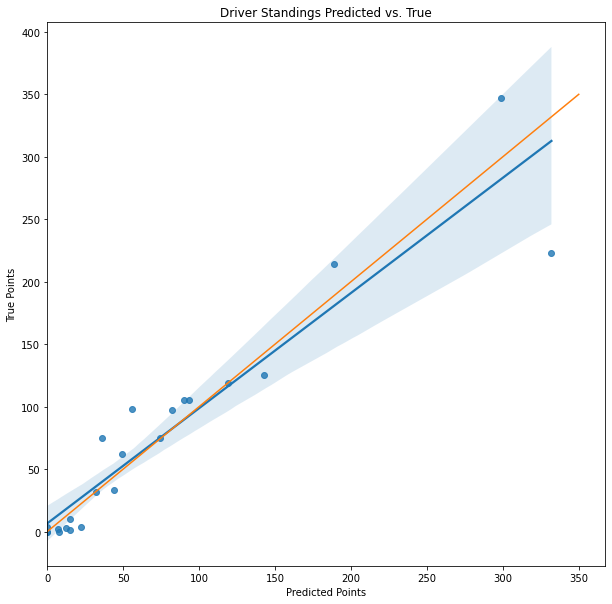

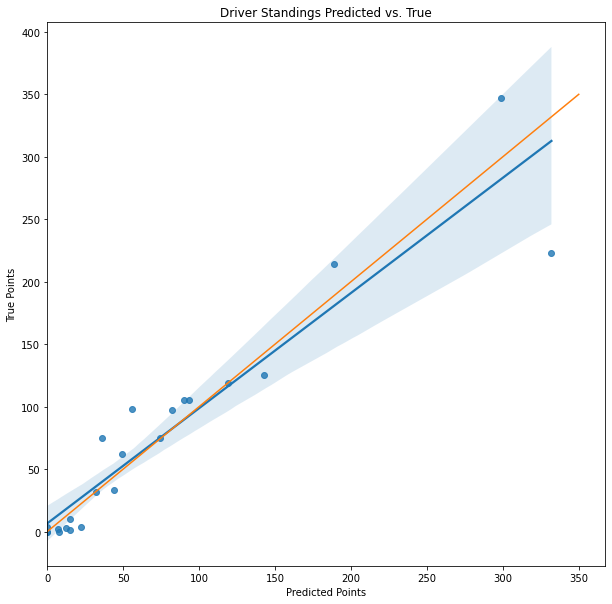

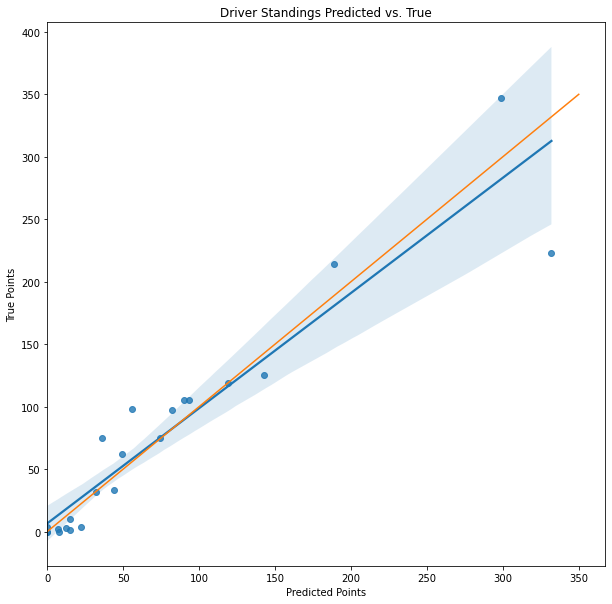

In [27]:
plt.subplots(figsize=(10, 10))
sns.regplot(data=driver_correlation_comparison, x='pred_points', y='true_points')
plt.plot([y_test.min(), 350], [y_test.min(), 350])
plt.title('Driver Standings Predicted vs. True')
plt.xlabel('Predicted Points')
plt.ylabel('True Points')

# Constructor Standings

In [ ]:
final_constructors

Text(0, 0.5, 'True Points')

Text(0, 0.5, 'True Points')

Text(0, 0.5, 'True Points')

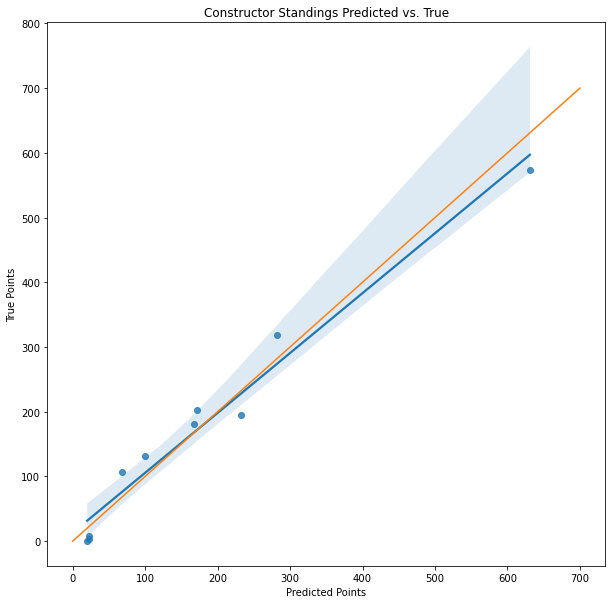

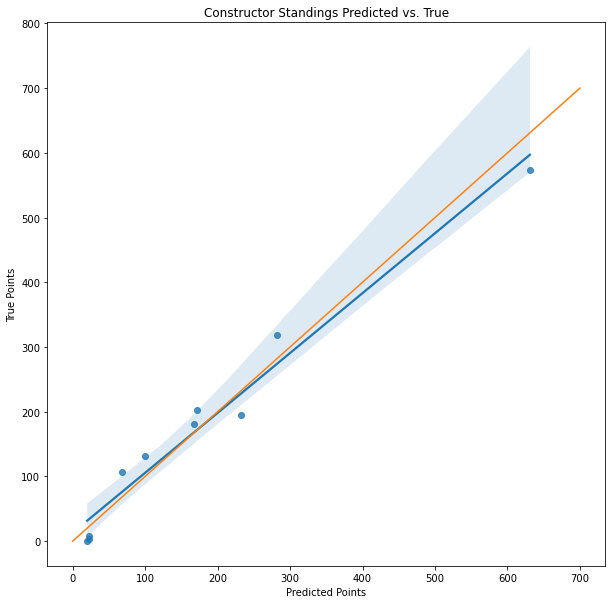

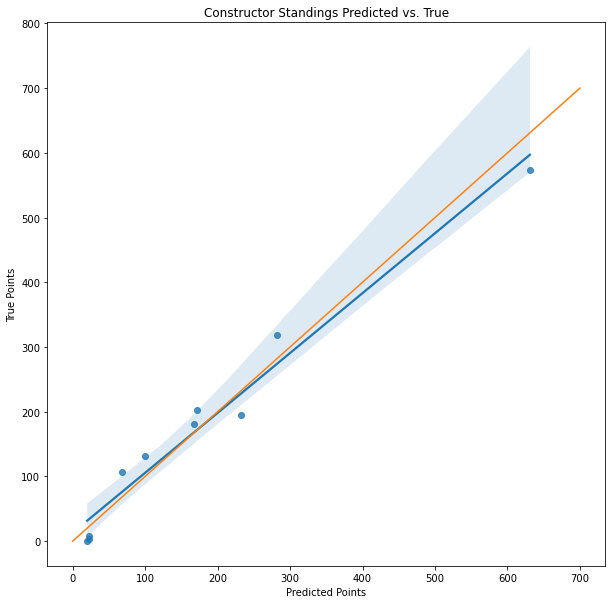

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.regplot(data=correlation_comparison, x='pred_points', y='true_points')
x_label=('Predicted Points')
plt.plot([y_test.min(), 700], [y_test.min(), 700])
plt.title('Constructor Standings Predicted vs. True')
plt.xlabel('Predicted Points')
plt.ylabel('True Points')

In [ ]:
# Save the model

# joblib.dump(pipe, 'ignore/models/f1model.pkl')

In [ ]:
# Load the saved model

# pipe = joblib.load('ignore/models/f1model.pkl')